### Second Part: Tests over data

In [1]:
import os
import sys
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import math


parameters = {}
with open("../parameters.yml", 'r') as stream:
    try:
        parameters = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

csvFile = '../src/data/processed/' + parameters['parsed_file']
tweets = pd.read_csv(csvFile, sep=',')


repliesCsvFile = '../src/data/processed/' + parameters['reply_file']
replies = pd.read_csv(repliesCsvFile, sep=',')

dataCsvFile = '../src/data/classes/' + parameters['class_name'] + '/' + 'index.csv'
data = pd.read_csv(dataCsvFile, sep='\t')
data = data.append({'name': 'other', 'token': 'other', 'tags': ''}, ignore_index=True)


### E- Topic based approach

In [2]:
processed = {
    't_hate': 0, 't_all': 0,  # trump's hate
    'h_hate': 0, 'h_all': 0, # hurricane hate
    'g_hate': 0, 'g_all': 0 # general hate
}

hurricaneTags = ['dorian', 'bhamas', 'hurricane', 'carolina', 'alabama']

for index, element in tweets.iterrows():
    vote = str(element['vote'])
    found = []
    if 'nan' == vote:
        continue
    if '0.0' != vote: 
        # detected politicians:
        politicians = element['matches'].split("####")
        for politician in politicians:
            for position, datum in data.iterrows():
                if politician.startswith(datum['token']):
                    if politician in found:
                        continue
                    found.append(politician)
                    # check replies
                    tempest_replies = replies.loc[replies['tweet_id'] == element['tweet_id']]
                    # check hates
                    tempest_hate = tempest_replies.loc[tempest_replies['automatic'] == 1]
                    if 'Donald_Trump' == datum['token']:
                        processed['t_hate'] = processed['t_hate'] + len(tempest_hate)
                        processed['t_all'] = processed['t_all'] + len(tempest_hate)

                        
for index, element in replies.iterrows():
    is_general = True
    text = element['text'].lower()
    if 'trump' in text:
        is_general = False
        processed['t_all'] = processed['t_all'] + 1
        if element['automatic'] == 1:
            processed['t_hate'] = processed['t_hate'] + 1     
    for hurricaneTag in hurricaneTags:
        if hurricaneTag in text:
            is_general = False
            processed['h_all'] = processed['h_all'] + 1
            if element['automatic'] == 1:
                processed['h_hate'] = processed['h_hate'] + 1
            break
    if not is_general:
        processed['g_all'] = processed['g_all'] + 1
        if element['automatic'] == 1:
            processed['g_hate'] = processed['g_hate'] + 1     
    
print(processed)                    

{'t_hate': 328, 't_all': 1135, 'h_hate': 2, 'h_all': 14, 'g_hate': 123, 'g_all': 937}


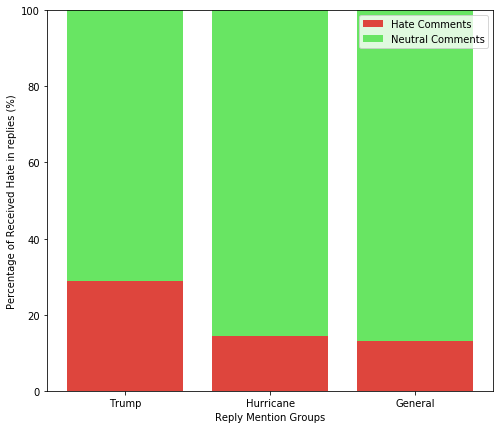

In [3]:
percentages = [0, 0 , 0];
negativePercentages = [100, 100 , 100];
titles = ['Trump', 'Hurricane', 'General']
percentages[0] = processed['t_hate'] * 100 / processed['t_all']
negativePercentages[0] = negativePercentages[0] - percentages[0]
percentages[1] = processed['h_hate'] * 100 / processed['h_all']
negativePercentages[1] = negativePercentages[1] - percentages[1]
percentages[2] = processed['g_hate'] * 100 / processed['g_all']
negativePercentages[2] = negativePercentages[2] - percentages[2]

# Hate distribtion:
plt.figure(figsize=(8,7))
plt.bar(titles, percentages, color='#de453d', label='Hate Comments')
plt.bar(titles, negativePercentages, bottom=percentages, color='#68e563', label='Neutral Comments')
plt.xlabel('Reply Mention Groups')
plt.ylabel('Percentage of Received Hate in replies (%)')
plt.ylim(0, 100)
plt.legend()
plt.show()


### F- Outlet-based Hatred

In [43]:
channelsFile = '../src/dataset/' + parameters['index_file']
channels = pd.read_csv(channelsFile, sep=',')
channels['all_comments'] = 1
channels['hate_comments'] = 0

for index, channel in channels.iterrows():
    account = channel['Official Twitter Account'].replace("@", "")
    account = account.replace(" ", "")
    account = account.replace("‏", "")
    account = account.replace(")", "")
    base_tweets = tweets.loc[  (tweets['user_id'] == account) | 
                               (tweets['text'].str.contains('@' + account))
                            ]
    for indexBase, element in base_tweets.iterrows():
        tempest_replies = replies.loc[replies['tweet_id'] == element['tweet_id']]
        if 0 ==len(tempest_replies):
            continue
            
        value = channels.loc[index, 'all_comments']
        channels.loc[index, 'all_comments'] = value + len(tempest_replies)                
        hate_replies = tempest_replies.loc[0 < tempest_replies['automatic']]
        channels.loc[index, 'hate_comments'] = channels.loc[index, 'hate_comments'] + len(hate_replies)            
        

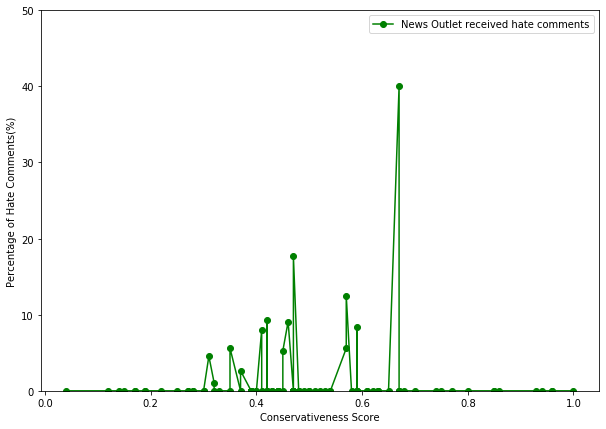

,Official Twitter Account,Media name,Conservative score,leaning,all_comments,hate_comments,hate_index
0,@timesofindia,Times of India,0.04,NaN,1,0,0.000000
1,@TheEconomist ‏,The Economist,0.12,NaN,1,0,0.000000
2,@northjersey,North Jersey.com,0.14,NaN,1,0,0.000000
3,@ocregister,Orange Country Register,0.15,NaN,1,0,0.000000
4,@mercnews),San Jose Mercury News,0.17,NaN,1,0,0.000000
5,@njdotcom,NewJersey.com,0.17,NaN,1,0,0.000000
6,@sfchronicle ‏,San Francisco Chronicle,0.19,NaN,1,0,0.000000
7,@baltimoresun ‏,Baltimore Sun,0.19,NaN,1,0,0.000000
8,@hartfordcourant ‏,Hartford Courant,0.22,NaN,1,0,0.000000
9,@Jerusalem_Post ‏,Jerusalem Post,0.25,NaN,1,0,0.000000


In [70]:
channels['hate_index'] = channels['hate_comments'] * 100 / channels['all_comments']

plt.figure(figsize=(10,7))
plt.plot(channels['Conservative score'],
         channels['hate_index'], 
         linestyle='-', 
         marker='o',
         color='green', 
         label='News Outlet received hate comments')
plt.xlabel('Conservativeness Score')
plt.ylabel('Percentage of Hate Comments(%)')
plt.ylim(0, 50)
plt.legend()
plt.show()


channels

### G- Proof of Face Recognition's Accuracy Problem - selecting a random sample

- Grabbed random data should be manually checked to find accuracy of the face recognition results follow:

### Checking accuracy of Political Actors:

In [5]:
accuracies = {}
accuracies[0] = {}
accuracies[1] = {}
accuracies[2] = {}
accuracies[3] = {}

Sample 1:

In [6]:
# make sample only if it doesn't exist:
if not os.path.exists( '../src/data/processed/' + parameters['manual_file']): 
    valid_tweets = tweets.loc[0 < tweets['vote']]
    # finding samples for each politician
    for position, datum in data.iterrows():
        my_tweets = valid_tweets.loc[valid_tweets['matches'].str.contains(datum['token'])]
        k = math.ceil(len(my_tweets)/5)
        if len(my_tweets) < k:
            continue
        samples = my_tweets.sample(k, replace=True)
        samples['tag'] = datum['token']
        samples['manual'] = '0'
        is_header_active = not os.path.exists( '../src/data/processed/' + parameters['manual_file'])
        method = 'a+'
        if is_header_active:
            method = 'w+'
        with open( '../src/data/processed/' + parameters['manual_file'], method, encoding="utf-8") as csvFile:
            samples.to_csv(csvFile, header=is_header_active, index=False)


manualsFile = '../src/data/processed/' + parameters['manual_file']
manuals = pd.read_csv(manualsFile, sep=',')


for position, datum in data.iterrows():
    my_tweets = manuals.loc[manuals['tag'] == datum['token']]
    if 0 == len(my_tweets): 
        continue 
    manuallyCorrect = my_tweets.loc[my_tweets['manual'] == 1]
    # print(len(manuallyCorrect))
    accuracies[0][datum['token']]= len(manuallyCorrect) * 100 / len(my_tweets) 
    

Sample 2:

In [7]:
# make sample only if it doesn't exist:
if not os.path.exists( '../src/data/processed/' + parameters['manual_file_2']): 
    valid_tweets = tweets.loc[0 < tweets['vote']]
    # finding samples for each politician
    for position, datum in data.iterrows():
        my_tweets = valid_tweets.loc[valid_tweets['matches'].str.contains(datum['token'])]
        k = math.ceil(len(my_tweets)/5)
        if len(my_tweets) < k:
            continue
        samples = my_tweets.sample(k, replace=True)
        samples['tag'] = datum['token']
        samples['manual'] = '0'
        is_header_active = not os.path.exists( '../src/data/processed/' + parameters['manual_file_2'])
        method = 'a+'
        if is_header_active:
            method = 'w+'
        with open( '../src/data/processed/' + parameters['manual_file_2'], method, encoding="utf-8") as csvFile:
            samples.to_csv(csvFile, header=is_header_active, index=False)


manualsFile = '../src/data/processed/' + parameters['manual_file_2']
manuals = pd.read_csv(manualsFile, sep=',')


for position, datum in data.iterrows():
    my_tweets = manuals.loc[manuals['tag'] == datum['token']]
    if 0 == len(my_tweets): 
        continue 
    manuallyCorrect = my_tweets.loc[my_tweets['manual'] == 1]
    # print(len(manuallyCorrect))
    accuracies[1][datum['token']]= len(manuallyCorrect) * 100 / len(my_tweets) 
    
    

Sample 3:

In [8]:
csvFile = '../src/data/processed/second_dataset.csv'
tweets2 = pd.read_csv(csvFile, sep=',')
# make sample only if it doesn't exist:
if not os.path.exists( '../src/data/processed/' + parameters['manual_file_3']):
    valid_tweets = tweets2.loc[0 < tweets2['vote']]
    # finding samples for each politician
    for position, datum in data.iterrows():
        my_tweets = valid_tweets.loc[valid_tweets['matches'].str.contains(datum['token'])]
        k = math.ceil(len(my_tweets)/5)
        if len(my_tweets) < k:
            continue
        samples = my_tweets.sample(k, replace=True)
        samples['tag'] = datum['token']
        samples['manual'] = '0'
        is_header_active = not os.path.exists( '../src/data/processed/' + parameters['manual_file_3'])
        method = 'a+'
        if is_header_active:
            method = 'w+'
        with open( '../src/data/processed/' + parameters['manual_file_3'], method, encoding="utf-8") as csvFile:
            samples.to_csv(csvFile, header=is_header_active, index=False)


manualsFile = '../src/data/processed/' + parameters['manual_file_3']
manuals = pd.read_csv(manualsFile, sep=',')


for position, datum in data.iterrows():
    my_tweets = manuals.loc[manuals['tag'] == datum['token']]
    if 0 == len(my_tweets): 
        continue 
    manuallyCorrect = my_tweets.loc[my_tweets['manual'] == 1]
    accuracies[2][datum['token']]= len(manuallyCorrect) * 100 / len(my_tweets) 
    

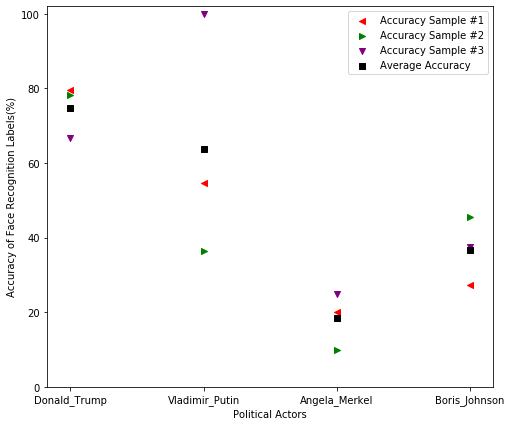

In [9]:
for position, datum in data.iterrows():
    if ('other' == datum['token']):
        continue
    accuracies[3][datum['token']] = (accuracies[0][datum['token']] + 
                                     accuracies[1][datum['token']] + 
                                     accuracies[2][datum['token']] )/3
    
    


plt.figure(figsize=(8,7))
plt.scatter(accuracies[0].keys(), accuracies[0].values(), marker='<', color='red', label='Accuracy Sample #1')
plt.scatter(accuracies[1].keys(), accuracies[1].values(), marker='>', color='green', label='Accuracy Sample #2')
plt.scatter(accuracies[2].keys(), accuracies[2].values(), marker='v', color='purple', label='Accuracy Sample #3')
plt.scatter(accuracies[3].keys(), accuracies[3].values(), marker=',', color='black', label='Average Accuracy')
plt.xlabel('Political Actors')
plt.ylabel('Accuracy of Face Recognition Labels(%)')
plt.ylim(0, 102)
plt.legend()
plt.show()